In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import scipy.stats as pearsonr
from sklearn import preprocessing
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn import cluster, metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.metrics import pairwise_distances_argmin_min
from statsmodels.graphics.gofplots import ProbPlot

In [2]:
#Importation du fichier source
data = pd.read_csv(r"C:\Users\elodi\Documents\DATA\Data Analyst\Projets\P7\data.csv")

### Mission 2 :
- Montrez la diversité des pays en termes de distribution de revenus à l'aide d'un graphique. Celui-ci représentera le revenu moyen (axe des ordonnées, sur une échelle logarithmique) de chacune des classes de revenus (axe des abscisses) pour 5 à 10 pays que vous aurez choisis pour montrer la diversité des cas.
- Représentez la courbe de Lorenz de chacun des pays choisis.
- Pour chacun de ces pays, représentez l'évolution de l'indice de Gini au fil des ans.
- Classez les pays par indice de Gini. Donnez la moyenne, les 5 pays ayant l'indice de Gini le plus élevé et les 5 pays ayant l'indice de Gini le plus faible. En quelle position se trouve la France ?

In [3]:
data.head()

,country_code,country,year,quantile,nb_quantiles,income,gdpppp,population,gini
0,ALB,Albania,2008,1,100,728.89795,7297,3002678.0,0.3
1,ALB,Albania,2008,2,100,916.66235,7297,3002678.0,0.3
2,ALB,Albania,2008,3,100,1010.91600,7297,3002678.0,0.3
3,ALB,Albania,2008,4,100,1086.90780,7297,3002678.0,0.3
4,ALB,Albania,2008,5,100,1132.69970,7297,3002678.0,0.3


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11600 entries, 0 to 11599
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country_code  11600 non-null  object 
 1   country       11600 non-null  object 
 2   year          11600 non-null  int64  
 3   quantile      11600 non-null  int64  
 4   nb_quantiles  11600 non-null  int64  
 5   income        11600 non-null  float64
 6   gdpppp        11600 non-null  object 
 7   population    11600 non-null  float64
 8   gini          11600 non-null  float64
dtypes: float64(3), int64(3), object(3)
memory usage: 815.8+ KB


In [5]:
#Conversion GDP PPP au bon format
data['gdpppp'] = data['gdpppp'].apply(lambda x: x.replace(',' ,'.'))

In [6]:
data['gdpppp'] = data['gdpppp'].astype(float)

Visualisation par Boxplot de la distribution des variables et des éventuels outliers

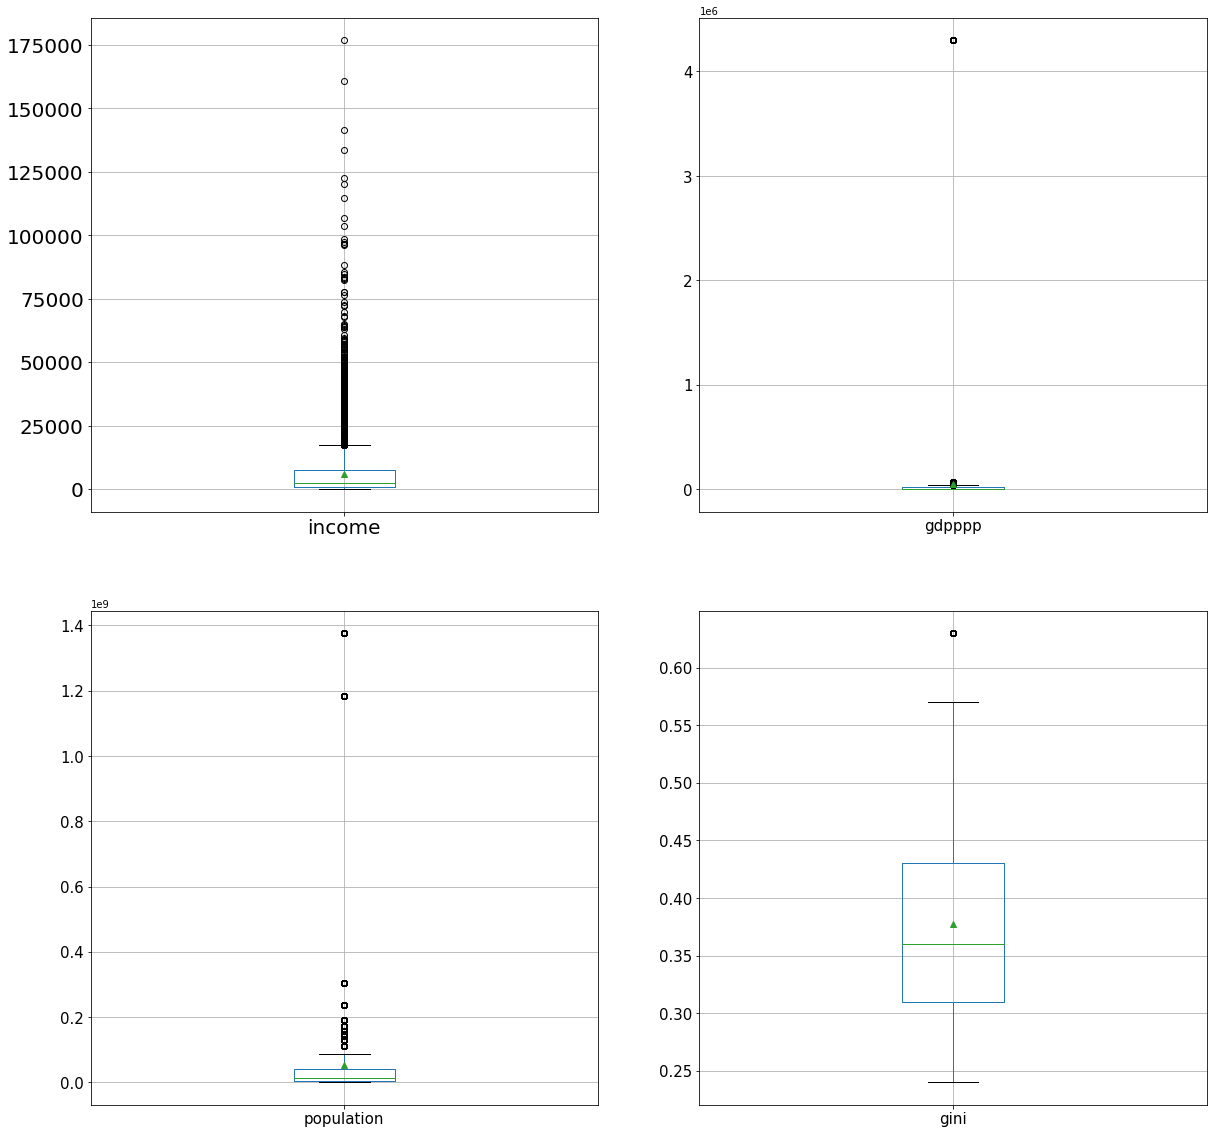

In [7]:
plt.figure(figsize=(20, 20))

plt.subplot(221)
data.iloc[:, [5]].boxplot(fontsize=20, widths=0.2, showmeans=True)
plt.subplot(222)
data.iloc[:, [6]].boxplot(fontsize=15, widths=0.2, showmeans=True)
plt.subplot(223)
data.iloc[:, [7]].boxplot(fontsize=15, widths=0.2, showmeans=True)
plt.subplot(224)
data.iloc[:, [8]].boxplot(fontsize=15, widths=0.2, showmeans=True)

plt.savefig('variables_boxplot.jpg')
plt.show()

In [8]:
#Identification de quelques outliers
display(data.sort_values(by='population', ascending=False).iloc[:1, :])
display(data.sort_values(by='gdpppp', ascending=False).iloc[:1, :])
display(data.sort_values(by='gini', ascending=False).iloc[:1, :])

,country_code,country,year,quantile,nb_quantiles,income,gdpppp,population,gini
1701,CHN,China,2007,2,100,234.15073,5712.0,1.376266e+09,0.48


,country_code,country,year,quantile,nb_quantiles,income,gdpppp,population,gini
3200,FJI,Fiji,2008,1,100,308.17334,4300332.0,845361.0,0.4


,country_code,country,year,quantile,nb_quantiles,income,gdpppp,population,gini
11471,ZAF,South Africa,2008,73,100,4620.958,9602.0,49779471.0,0.63


Les Iles Fiji seront exclues par la suite car leur valeur gdpppp est très influente.

Calcul revenus moyens par pays

In [9]:
avg_incomne = data[['country_code','income']].groupby('country_code').mean().reset_index()
avg_incomne.rename(columns={'income':'avg_income'}, inplace=True)
data = data.merge(avg_incomne, how='left', on='country_code')
data.head()

,country_code,country,year,quantile,nb_quantiles,income,gdpppp,population,gini,avg_income
0,ALB,Albania,2008,1,100,728.89795,7297.0,3002678.0,0.3,2994.829902
1,ALB,Albania,2008,2,100,916.66235,7297.0,3002678.0,0.3,2994.829902
2,ALB,Albania,2008,3,100,1010.91600,7297.0,3002678.0,0.3,2994.829902
3,ALB,Albania,2008,4,100,1086.90780,7297.0,3002678.0,0.3,2994.829902
4,ALB,Albania,2008,5,100,1132.69970,7297.0,3002678.0,0.3,2994.829902


Préparation du Dataframe pour le clustering

In [10]:
#La visualisation précédente des distributions de nos variables avait exposé quelques outliers. 
#Fiji exclues pour le clustering
clustering = data.copy()
clustering = clustering[clustering['country'] != 'Fiji'] 
clustering = (
            clustering
                .copy()
                .set_index('country')
)
clustering.head()

,country_code,year,quantile,nb_quantiles,income,gdpppp,population,gini,avg_income
country,,,,,,,,,
Albania,ALB,2008,1,100,728.89795,7297.0,3002678.0,0.3,2994.829902
Albania,ALB,2008,2,100,916.66235,7297.0,3002678.0,0.3,2994.829902
Albania,ALB,2008,3,100,1010.91600,7297.0,3002678.0,0.3,2994.829902
Albania,ALB,2008,4,100,1086.90780,7297.0,3002678.0,0.3,2994.829902
Albania,ALB,2008,5,100,1132.69970,7297.0,3002678.0,0.3,2994.829902


In [11]:
#Par simplification (gain en temps de calcul), le clustering sera fait sur le premier quantile)
clustering.drop_duplicates(subset=['country_code'], inplace=True)
clustering.head()

,country_code,year,quantile,nb_quantiles,income,gdpppp,population,gini,avg_income
country,,,,,,,,,
Albania,ALB,2008,1,100,728.89795,7297.0,3002678.0,0.30,2994.829902
Argentina,ARG,2008,1,100,254.08942,13220.0,40080160.0,0.45,5847.884654
Armenia,ARM,2008,1,100,366.61780,5611.0,2907618.0,0.29,1628.382785
Austria,AUT,2008,1,100,2958.07640,36193.0,8341532.0,0.30,16637.600204
Azerbaijan,AZE,2008,1,100,397.53983,8101.0,8821873.0,0.31,2357.429023


#### K-means

In [12]:
#Préparation des données
#Ici le clustering sera établi sur les valeurs des variables 'gdpppp' et 'gini'
X = clustering.loc[:, ['gdpppp', 'gini']].values
Y = clustering.index

In [13]:
#Centrage et réduction des données
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

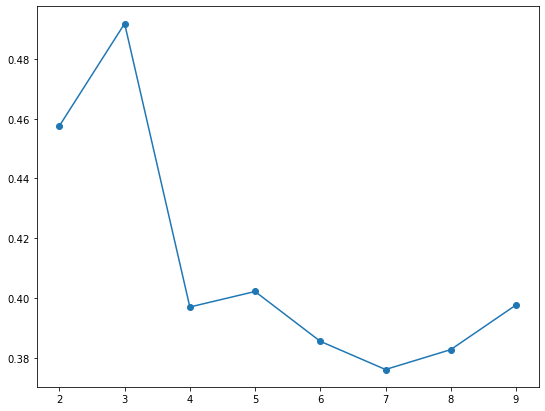

In [14]:
silhouettes = [] 

#Boucle itérative de 2 à 10 (clusters) pour tester les possibilités
for k in range(2, 10): 
    #Création et ajustement d'un modèle pour chaque k
    cls = cluster.KMeans(n_clusters=k)  
    cls.fit(X_scaled)
    
    #Stockage des coefficients associés
    silh = metrics.silhouette_score(X_scaled, cls.labels_)
    silhouettes.append(silh)
    
#Visualisation des valeurs de coefficient de silhouette pour chaque nombre de cluster
plt.figure(figsize=(9, 7))
plt.plot(range(2, 10), silhouettes, marker='o')

plt.savefig('silhouette.png')
plt.show()

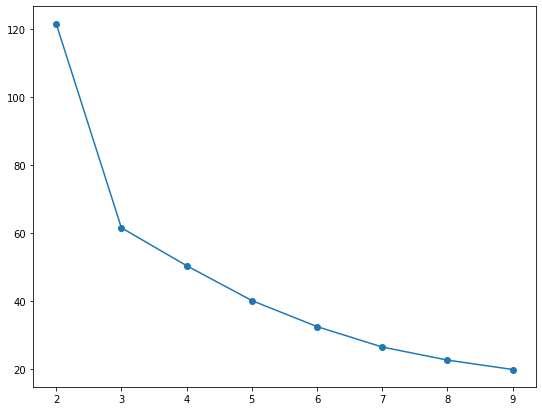

In [15]:
#On crée une liste dans laquelle on stocke les inerties
inerties=[]

#On fait une boucle de 2 à 9 pour tester toutes les possibilités
for k in range(2, 10):
    #pour chaque k, on crée un modèle et on l’ajuste
    km = cluster.KMeans(n_clusters=k)
    km.fit(X_scaled)
    #on stocke l’inertie associée
    inerties.append(km.inertia_)

#Visualisation des valeurs d'inertie pour chaque nombre de cluster
plt.figure(figsize=(9, 7))
plt.plot(range(2, 10), inerties, marker='o')


plt.savefig('inertie.png')
plt.show()

Clustering en K=3

In [16]:
cls3 = cluster.KMeans(n_clusters=3)
cls3.fit(X_scaled)

KMeans(n_clusters=3)

In [17]:
clusters_kmeans3 = cls3.labels_

In [18]:
centroids = cls3.cluster_centers_
pd.DataFrame(centroids, columns=['gdpppp', 'gini'], index=['cluster 0', 'cluster 1', 'cluster 2'])

,gdpppp,gini
cluster 0,-0.468430,-0.490201
cluster 1,-0.464263,1.222442
cluster 2,1.597543,-0.759228


In [19]:
#Index trié des clusters
idk = np.argsort(cls.labels_)

#Affichage des observations selon leurs clusters
df_cls_3 = pd.DataFrame(clustering.index[idk], cls3.labels_[idk]).reset_index()
df_cls_3 = df_cls_3.rename(columns={'index':'cluster'})

In [20]:
#Intégration des clusters dans "df_cls_3" et jointure avec le dataframe initial
df_cls = pd.merge(clustering, df_cls_3, on='country')
display(df_cls)

,country,country_code,year,quantile,nb_quantiles,income,gdpppp,population,gini,avg_income,cluster
0,Albania,ALB,2008,1,100,728.897950,7297.00000,3002678.0,0.30,2994.829902,0
1,Argentina,ARG,2008,1,100,254.089420,13220.00000,40080160.0,0.45,5847.884654,1
2,Armenia,ARM,2008,1,100,366.617800,5611.00000,2907618.0,0.29,1628.382785,0
3,Austria,AUT,2008,1,100,2958.076400,36193.00000,8341532.0,0.30,16637.600204,2
4,Azerbaijan,AZE,2008,1,100,397.539830,8101.00000,8821873.0,0.31,2357.429023,0
...,...,...,...,...,...,...,...,...,...,...,...
110,Vietnam,VNM,2006,1,100,234.266950,2578.00000,84617540.0,0.36,1377.773966,0
111,Occupied Palestinian Territory,PSE,2009,1,100,195.289900,3951.20000,3957670.0,0.36,1114.098514,0
112,Yemen,YEM,2008,1,100,162.951310,2224.00000,21892146.0,0.37,1042.635870,0
113,South Africa,ZAF,2008,1,100,60.490383,9602.00000,49779471.0,0.63,5617.904880,1


Liste des pays par cluster 

In [21]:
print(list(df_cls[df_cls['cluster'] == 0]['country'].unique()))

['Albania', 'Armenia', 'Azerbaijan', 'Burkina Faso', 'Bangladesh', 'Bulgaria', 'Bosnia and Herzegovina', 'Belarus', 'Bhutan', 'Egypt', 'Estonia', 'Georgia', 'Guinea', 'Croatia', 'Hungary', 'Indonesia', 'India', 'Iraq', 'Jordan', 'Kazakhstan', 'Kenya', 'Kyrgyzstan', 'Cambodia', 'Republic of Korea', 'Kosovo', "Lao People's Democratic Republic", 'Liberia', 'Sri Lanka', 'Lithuania', 'Latvia', 'Republic of Moldova', 'The Former Yugoslav Republic of Macedonia', 'Mali', 'Montenegro', 'Mongolia', 'Mauritania', 'Niger', 'Nepal', 'Pakistan', 'Poland', 'Romania', 'Sudan', 'Serbia', 'Syrian Arab Republic', 'Tajikistan', 'Timor-Leste', 'Turkey', 'United Republic Of Tanzania', 'Ukraine', 'Vietnam', 'Occupied Palestinian Territory', 'Yemen']


In [22]:
print(list(df_cls[df_cls['cluster'] == 1]['country'].unique()))

['Argentina', 'Bolivia', 'Brazil', 'Central African', 'Chile', 'China', "Côte d'Ivoire", 'Cameroon', 'Colombia', 'Costa Rica', 'Dominican Republic', 'Ecuador', 'Ghana', 'Guatemala', 'Honduras', 'Islamic Republic of Iran', 'Morocco', 'Madagascar', 'Mexico', 'Mozambique', 'Malawi', 'Malaysia', 'Nigeria', 'Nicaragua', 'Panama', 'Peru', 'Philippines', 'Paraguay', 'Russian Federation', 'El Salvador', 'Swaziland', 'Thailand', 'Uganda', 'Uruguay', 'Venezuela', 'South Africa', 'The Democratic Republic Of The Congo']


In [23]:
print(list(df_cls[df_cls['cluster'] == 2]['country'].unique()))

['Austria', 'Belgium', 'Canada', 'Cyprus', 'Czech Republic', 'Germany', 'Denmark', 'Spain', 'Finland', 'France', 'United Kingdom', 'Greece', 'Ireland', 'Iceland', 'Israel', 'Italy', 'Japan', 'Luxembourg', 'Netherlands', 'Norway', 'Portugal', 'Slovakia', 'Slovenia', 'Sweden', 'Taiwan', 'United States']


In [24]:
#Taille des 3 clusters
print(str(len(df_cls[df_cls['cluster'] == 0])) + " clusters dans la première partition")
print(str(len(df_cls[df_cls['cluster'] == 1])) + " clusters dans la seconde partition")
print(str(len(df_cls[df_cls['cluster'] == 2])) + " clusters dans la troisième partition")

52 clusters dans la première partition
37 clusters dans la seconde partition
26 clusters dans la troisième partition


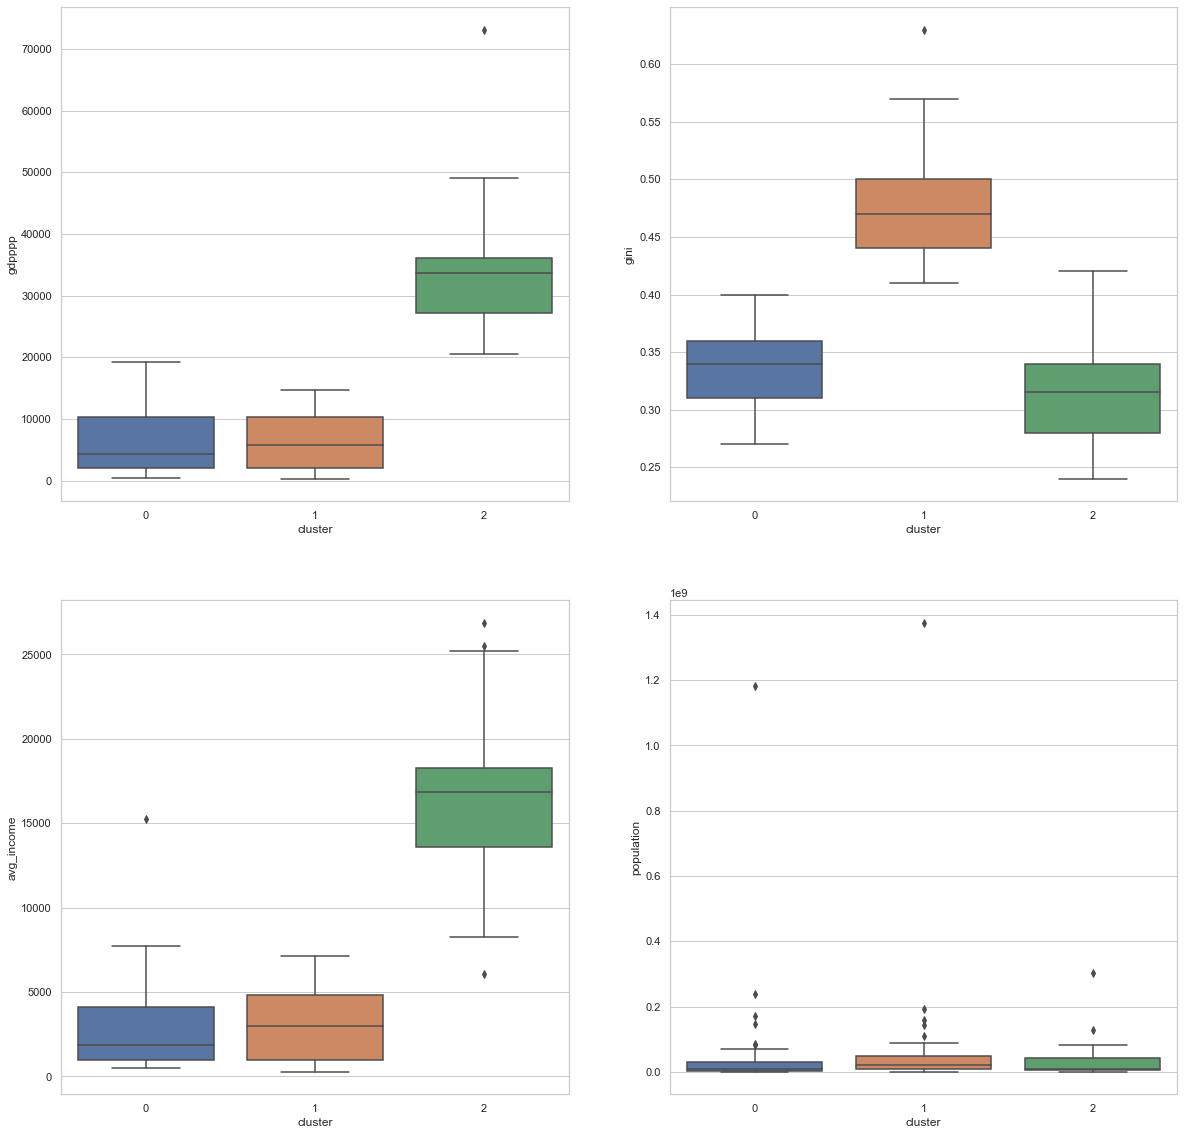

In [25]:
# Visualisation des groupes 
plt.figure(figsize=(20, 20))
sns.set(style="whitegrid")


plt.subplot(221)
sns.boxplot(data=df_cls, x='cluster', y='gdpppp')

plt.subplot(222)
sns.boxplot(data=df_cls, x='cluster', y='gini')

plt.subplot(223)
sns.boxplot(data=df_cls, x='cluster', y='avg_income')

plt.subplot(224)
sns.boxplot(data=df_cls, x='cluster', y='population')

plt.savefig('visualisation__cluster_bloxpot.png')
plt.show(block=False)

Choix des pays du cluster  2 : le gdpppp est plus important que pour les autres partitions, les pays ont un indice de Gini très éloigné de 1 indiquant une meilleure répartition des revenus.

In [26]:
#Affichage des pays les plus contributeurs : restriction cluster 1
di = np.sum(X_scaled**2,axis=1)
ctr_indiv_inertie = pd.DataFrame({'c_inertie':di, 'country':clustering.index, 
                                  'country_code': df_cls['country_code'], 'cluster': df_cls['cluster'], 
                                  'gdpppp': df_cls['gdpppp'], 'gini': df_cls['gini']}).sort_values(by='c_inertie',
                                                                                                   ascending=False)
ctr_indiv_inertie[ctr_indiv_inertie['cluster'] == 2]

,c_inertie,country,country_code,cluster,gdpppp,gini
62,21.617914,Luxembourg,LUX,2,73127.0,0.33
80,9.468682,Norway,NOR,2,49070.0,0.27
108,5.649078,United States,USA,2,43261.0,0.41
25,5.136822,Denmark,DNK,2,34130.0,0.25
79,4.925111,Netherlands,NLD,2,38065.0,0.29
44,4.826734,Ireland,IRL,2,39268.0,0.31
96,4.186782,Sweden,SWE,2,34371.0,0.28
3,4.144422,Austria,AUT,2,36193.0,0.30
95,4.074702,Slovenia,SVN,2,27197.0,0.24
31,4.001214,Finland,FIN,2,33626.0,0.28


In [27]:
#Liste des pays retenus 
country_list = ['Luxembourg', 'Sweden', 'Spain', 'France', 'Norway', 'United States', 'Denmark', 'Austria', 'Czech Republic']
country_code = ['LUX', 'SWE', 'ESP', 'FRA', 'NOR', 'USA', 'DNK', 'AUT', 'CZE']

In [28]:
df_pays_analyse = data[data["country_code"].isin(country_code)==True]
display(df_pays_analyse)

,country_code,country,year,quantile,nb_quantiles,income,gdpppp,population,gini,avg_income
300,AUT,Austria,2008,1,100,2958.0764,36193.0,8341532.0,0.30,16637.600204
301,AUT,Austria,2008,2,100,4893.4673,36193.0,8341532.0,0.30,16637.600204
302,AUT,Austria,2008,3,100,5459.6490,36193.0,8341532.0,0.30,16637.600204
303,AUT,Austria,2008,4,100,5923.5854,36193.0,8341532.0,0.30,16637.600204
304,AUT,Austria,2008,5,100,6380.2780,36193.0,8341532.0,0.30,16637.600204
...,...,...,...,...,...,...,...,...,...,...
10994,USA,United States,2008,96,100,69926.3700,43261.0,303486012.0,0.41,25503.581661
10995,USA,United States,2008,97,100,77634.8200,43261.0,303486012.0,0.41,25503.581661
10996,USA,United States,2008,98,100,88482.8400,43261.0,303486012.0,0.41,25503.581661
10997,USA,United States,2008,99,100,106765.2600,43261.0,303486012.0,0.41,25503.581661


#### Diversité des distributions de revenus sur les pays sélectionnés

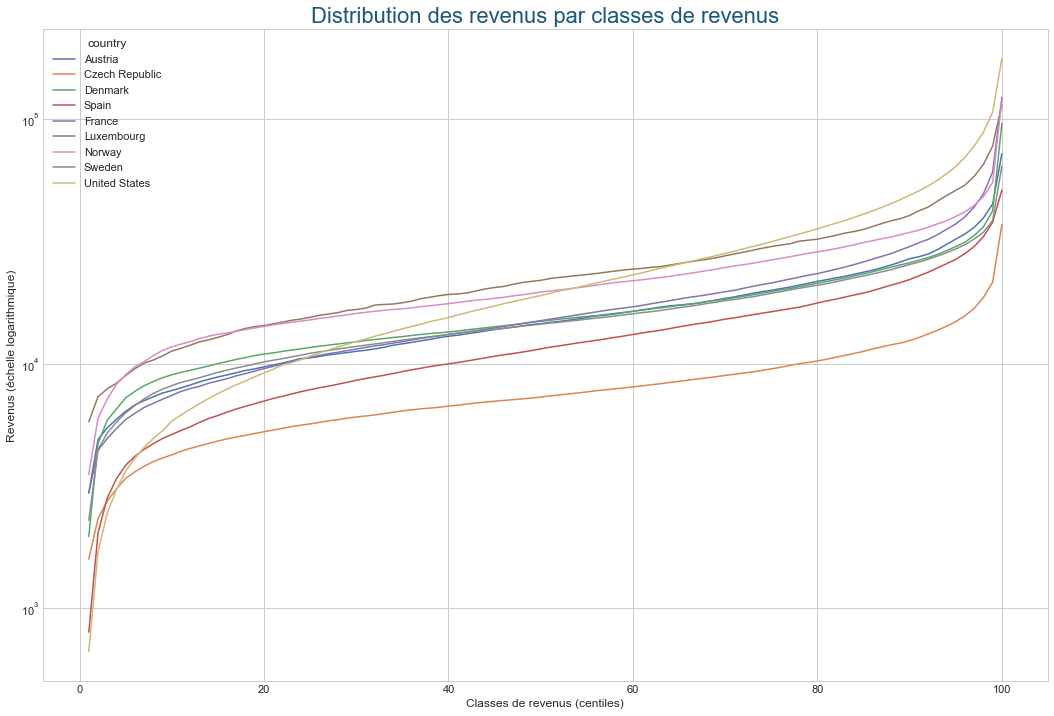

In [29]:
fig=plt.figure(figsize=(18,12))
plt.style.use('seaborn-whitegrid')
sns.lineplot(data=df_pays_analyse, x="quantile", y="income", hue="country")
plt.yscale('log')
plt.title("Distribution des revenus par classes de revenus", fontsize=22, color="#1c587c")
plt.xlabel("Classes de revenus (centiles)")
plt.ylabel("Revenus (échelle logarithmique)")

plt.savefig('distribution_revenus.png')
plt.show()

#### Courbe de Lorenz

C:\Users\elodi\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\elodi\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


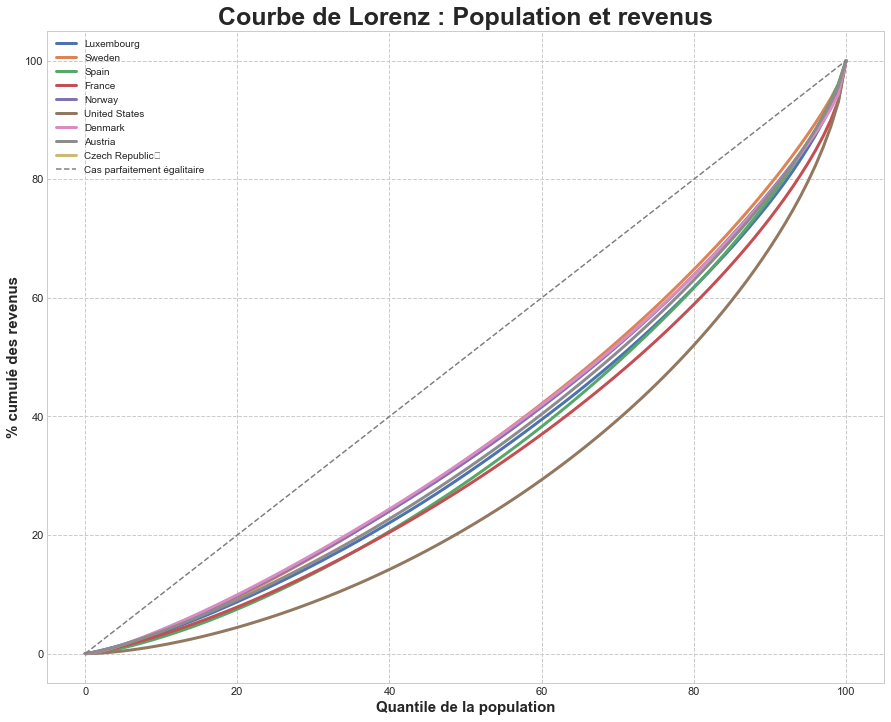

In [30]:
plt.figure(figsize = (15, 12))
list_gini = []

for count in country_list:
    # revenus_total_pays : Revenus total sur les 100 centiles
    revenus_total_pays = data[data.country==count]['income'].sum()
    
    dep = data[data.country==count]['income'].values
    n = len(dep)
    
    # lorenz : Courbe de lorenz
    lorenz = (np.cumsum(np.sort(data[data.country==count]['income']))/revenus_total_pays)*100
    lorenz = np.append([0],lorenz) 
    x = np.append([0],data[data.country==count]['quantile'])    
    plt.plot(x,lorenz,linewidth=3, label=count)

    
    
plt.plot([0,100],[0,100],'grey',linestyle='--',linewidth=1.5, label='Cas parfaitement égalitaire')
plt.xlabel('Quantile de la population',fontsize=15,fontweight = 'bold')
plt.ylabel('% cumulé des revenus',fontsize=15,fontweight = 'bold')
plt.legend(loc='upper left',fontsize=10)
plt.grid(True,linestyle='--')
plt.title('Courbe de Lorenz : Population et revenus',fontsize=25,fontweight = 'bold')

plt.savefig('lorenz.png')
plt.show()

#### Evolution de l'indice de Gini entre 2004 et 2011 

In [31]:
gini = pd.read_csv(r"C:\Users\elodi\Downloads\indice_gini.csv", skiprows=4).reset_index()
#On sélectionne les années couvertes par l'analyse
gini_columns = []
for value in gini.columns:
    gini_columns.append(value)
    
gini_vars = [year for year in gini_columns if year in (['2004', '2006', '2007', '2008', '2009', '2010', '2011'])]

In [32]:
#Mise en forme du dataframe pour obtenir uniquement les indices de Gini disponibles sur les années ci-dessus
gini_melt = pd.melt(gini, id_vars =['Country Code', 'Country Name'], value_vars = gini_vars, var_name ='year', 
                    value_name ='gini')
gini_melt.rename(columns={'Country Code':'country_code', 'Country Name':'country'}, inplace=True)
gini_melt['gini'] = round(gini_melt['gini']/100, 2)
gini_melt.dropna(inplace=True)
gini_melt['year'] = gini_melt['year'].astype(int)
gini_melt

,country_code,country,year,gini
9,ARG,Argentina,2004,0.48
10,ARM,Armenia,2004,0.38
13,AUS,Australia,2004,0.33
14,AUT,Austria,2004,0.30
15,AZE,Azerbaijan,2004,0.27
...,...,...,...,...
1844,UKR,Ukraine,2011,0.25
1846,URY,Uruguay,2011,0.42
1847,USA,United States,2011,0.41
1857,XKX,Kosovo,2011,0.28


C:\Users\elodi\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\elodi\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


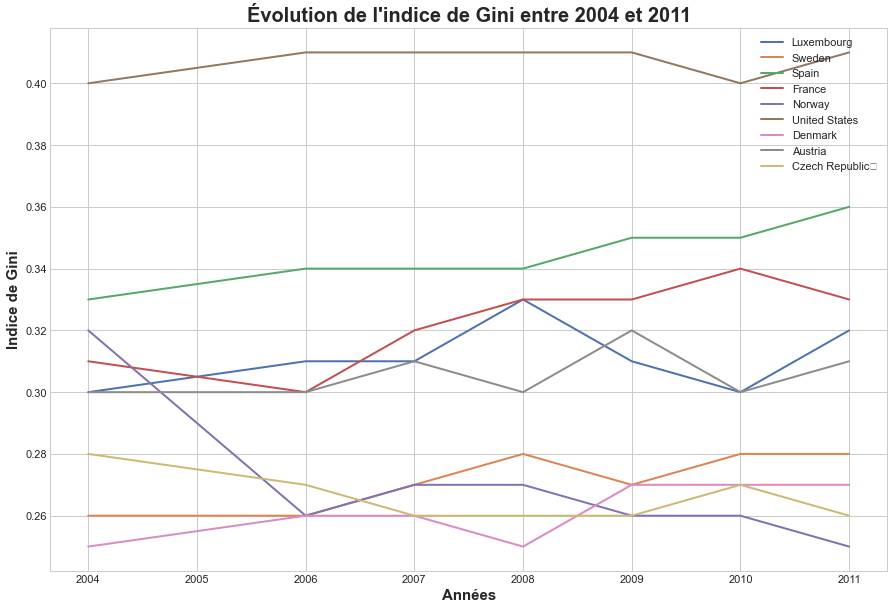

In [33]:
plt.figure(figsize=(15,10))

for c_code, c_name in zip(country_code, country_list):   
    plt.plot(gini_melt[gini_melt['country_code']==c_code]['year'],
             gini_melt[gini_melt.country_code==c_code]['gini'],linewidth=2, label=c_name)

plt.title("Évolution de l'indice de Gini entre 2004 et 2011", fontsize=20, fontweight='bold')
plt.xlabel("Années", fontsize=15, fontweight='bold')
plt.ylabel("Indice de Gini", fontsize=15, fontweight='bold')
plt.legend()

plt.savefig('evolution_gini.png')
plt.show()

#### Classement des pays selon leur indice de Gini

In [34]:
#Utilisation de la fonction .rank() pour déterminer la position de chaque pays, dont la France
gini_group = pd.DataFrame(gini_melt.groupby(['country_code', 'country']).gini.mean()).reset_index()
gini_group['rang'] = gini_group['gini'].rank(ascending=True)
gini_group.head()

,country_code,country,gini,rang
0,AGO,Angola,0.430000,99.0
1,ALB,Albania,0.300000,20.5
2,ARG,Argentina,0.451429,111.0
3,ARM,Armenia,0.307143,24.0
4,AUS,Australia,0.343333,52.0


In [35]:
#5 pays ayant l'indice de Gini le plus élevé
gini_group.sort_values(by='gini', ascending=False).head()

,country_code,country,gini,rang
138,ZAF,South Africa,0.63,141.0
92,NAM,Namibia,0.61,140.0
18,BWA,Botswana,0.60,139.0
19,CAF,Central African Republic,0.56,137.5
29,COM,Comoros,0.56,137.5


In [36]:
#5 pays ayant l'indice de Gini le plus faible
gini_group.sort_values(by='gini', ascending=True).head()

,country_code,country,gini,rang
116,SVN,Slovenia,0.245714,1.0
35,DNK,Denmark,0.261429,2.0
115,SVK,Slovak Republic,0.262857,3.0
33,CZE,Czech Republic,0.265714,4.0
130,UKR,Ukraine,0.268571,5.0


In [37]:
#Position de la France 
gini_group[gini_group.country == 'France']

,country_code,country,gini,rang
45,FRA,France,0.322857,35.0


In [38]:
data.to_csv("df_7.csv", index = False)